In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/Work_from_home/BRATS_segmentation/ignite_classification/

/content/drive/My Drive/Work_from_home/BRATS_segmentation/ignite_classification


In [3]:
!pwd
!ls

/content/drive/My Drive/Work_from_home/BRATS_segmentation/ignite_classification
argnames.json  classification  pipeline     train.py
checkpt        data_directory  train.ipynb


In [4]:
%pip install -q "monai[tqdm, nibabel, gdown, ignite]"
%pip install mlflow --quiet
%pip install optuna --quiet

In [5]:
%reset -f
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.close('all')
clear_output()

In [6]:
%reset -f
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.close('all')
clear_output()

import torch
import mlflow
import mlflow.pytorch
from torchsummary import summary
from mlflow.tracking import MlflowClient
from pipeline.utils import parseInputs

In [ ]:
!nvidia-smi

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

In [9]:
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(r.data.params))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

In [10]:
def train(cfg, overrides=None):
    with mlflow.start_run() as run:
        if overrides is not None:
            cfg.update_from_args(overrides)
        
        # mlflow.log_params(cfg.config)
        
        task = cfg.get_task()
        
        task.model = cfg.get_model_instance()

        task.dataset = cfg.get_datahelper_instance()
        
        task.criterion = cfg.get_criterion()
        
        task.optimizer, task.scheduler = cfg.get_optimizer(task.model.parameters())
        
        # summary(task.model.to(device),(1,128,128,128))
        
        change_max_epochs = False
        if change_max_epochs:
            task.maxepochs = 2
        
        change_batchsize = False
        if change_batchsize:
            task.batchsize = 1
        
        trainer = task.get_trainer()
        task.adding_Event_handlers(trainer)

        # mlflow.pytorch.log_model(task.model, "model")
        # print(run.info, run.data)
        # print_auto_logged_info(mlflow.get_run(run_id = run.info.run_id))

        return trainer,task

In [11]:
cfg, my_args = parseInputs()

instantiate: got type monai.networks.nets.densenet121
	kwargs: {'spatial_dims': 3, 'in_channels': 1, 'out_channels': 2}


  0%|          | 0/68 [00:00<?, ?it/s]

instantiate: got type classification.data.brats.DataHelper
	args: {'partition': {'stratified': True, 'ratios': [0.8, 0.1, 0.1], 'sampling': 0.3}}

Reading training data


  0%|          | 0/8 [00:00<?, ?it/s]


Reading validation data


  0%|          | 0/8 [00:00<?, ?it/s]


Reading test data


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]




instantiate: got type torch.nn.CrossEntropyLoss
	kwargs: {'reduction': 'mean'}
instantiate: got type torch.optim.Adam
	args: [<generator object Module.parameters at 0x7f1221b8bfc0>]
	kwargs: {'lr': 0.001}
instantiate: got type torch.optim.lr_scheduler.ReduceLROnPlateau
	kwargs: {'factor': 0.1, 'patience': 5, 'threshold': 10, 'threshold_mode': 'abs', 'min_lr': 1e-06, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)}


[I 2021-02-03 20:21:47,738] A new study created in memory with name: no-name-4dddb552-3d29-438c-a06e-f980e576fd3f
Avg training Loss(in model.train() mode!) = 0.0000:   0%|          | 0/5 [00:00<?, ?it/s]


 Entering the hyper-parameter optimization: 



[I 2021-02-03 20:22:50,240] Trial 0 finished with value: 0.9681760920211673 and parameters: {'batchsize': 4, 'max_epochs': 5}. Best is trial 0 with value: 0.9681760920211673.
[I 2021-02-03 20:24:08,594] Trial 1 finished with value: 2.561003252863884 and parameters: {'batchsize': 3, 'max_epochs': 5}. Best is trial 0 with value: 0.9681760920211673.
[I 2021-02-03 20:25:28,184] Trial 2 finished with value: 0.5937996450811625 and parameters: {'batchsize': 3, 'max_epochs': 5}. Best is trial 2 with value: 0.5937996450811625.
[I 2021-02-03 20:27:35,807] Trial 3 finished with value: 0.41576670361246215 and parameters: {'batchsize': 2, 'max_epochs': 7}. Best is trial 3 with value: 0.41576670361246215.
[I 2021-02-03 20:28:56,177] Trial 4 finished with value: 0.5406104326248169 and parameters: {'batchsize': 4, 'max_epochs': 6}. Best is trial 3 with value: 0.41576670361246215.
Engine run is terminating due to exception: Trial was pruned at 7 epoch..
[I 2021-02-03 20:31:03,864] Trial 5 pruned. Trial


study statistics:
Number of trials = 12
Number of pruned trials = 4
Number of completed trials = 8
Lowest ce_loss:  0.3955119689926505
best params:
batchsize:2
max_epochs:8

Old lr = 0.001 



/usr/local/lib/python3.6/dist-packages/ignite/contrib/handlers/lr_finder.py:154: UserWarning:

Run completed without loss diverging, increase end_lr, decrease diverge_th or look at lr_finder.plot()



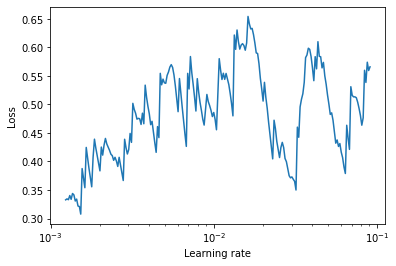

Mini-batch loss = 0.00:   0%|          | 0/34 [00:00<?, ?it/s]


New lr suggested by lr_finder = 0.007337467970651381 



In [ ]:
trainer,task = train(cfg, my_args)

In [ ]:
trainer.run(data = task.train_loader);

Mini-batch loss = 2.16: 100%|██████████| 17/17 [01:05<00:00,  1.93s/it]

Training Results - Epoch: 1/20  Avg accuracy: 0.31 Avg loss: 7.83


Mini-batch loss = 2.16: 100%|██████████| 17/17 [01:06<00:00,  1.93s/it]

Validation Results - Epoch: 1/20  Avg accuracy: 0.25 Avg loss: 7.56
updated_lr =  0.008082822192522716


Mini-batch loss = 0.87: 100%|██████████| 17/17 [01:48<00:00,  1.92s/it]

Training Results - Epoch: 2/20  Avg accuracy: 0.69 Avg loss: 1.54


Mini-batch loss = 0.87: 100%|██████████| 17/17 [01:49<00:00,  1.92s/it]

Validation Results - Epoch: 2/20  Avg accuracy: 0.75 Avg loss: 0.47
updated_lr =  0.008082822192522716


Mini-batch loss = 0.60: 100%|██████████| 17/17 [02:31<00:00,  1.93s/it]

Training Results - Epoch: 3/20  Avg accuracy: 0.69 Avg loss: 13.53


Mini-batch loss = 0.60: 100%|██████████| 17/17 [02:32<00:00,  1.93s/it]

Validation Results - Epoch: 3/20  Avg accuracy: 0.75 Avg loss: 1.26
updated_lr =  0.008082822192522716


Mini-batch loss = 0.69: 100%|██████████| 17/17 [03:14<00:00,  1.91s/it]

Training Results - Epoch: 4/20  Avg accuracy: 0.69 Avg loss: 0.78


Mini-batch loss = 0.69: 100%|██████████| 17/17 [03:15<00:00,  1.91s/it]

Validation Results - Epoch: 4/20  Avg accuracy: 0.75 Avg loss: 0.53
updated_lr =  0.008082822192522716


Mini-batch loss = 0.54: 100%|██████████| 17/17 [03:57<00:00,  1.92s/it]

Training Results - Epoch: 5/20  Avg accuracy: 0.69 Avg loss: 0.55


Mini-batch loss = 0.54: 100%|██████████| 17/17 [03:58<00:00,  1.92s/it]

Validation Results - Epoch: 5/20  Avg accuracy: 0.75 Avg loss: 0.57
updated_lr =  0.008082822192522716


Mini-batch loss = 0.87: 100%|██████████| 17/17 [04:40<00:00,  1.90s/it]

Training Results - Epoch: 6/20  Avg accuracy: 0.69 Avg loss: 0.58


Mini-batch loss = 0.87: 100%|██████████| 17/17 [04:41<00:00,  1.90s/it]

Validation Results - Epoch: 6/20  Avg accuracy: 0.75 Avg loss: 0.57
updated_lr =  0.008082822192522716


Mini-batch loss = 0.75: 100%|██████████| 17/17 [05:23<00:00,  1.90s/it]

Training Results - Epoch: 7/20  Avg accuracy: 0.69 Avg loss: 0.59


Mini-batch loss = 0.75: 100%|██████████| 17/17 [05:24<00:00,  1.90s/it]

Validation Results - Epoch: 7/20  Avg accuracy: 0.75 Avg loss: 0.57
updated_lr =  0.0008082822192522717


Mini-batch loss = 0.57: 100%|██████████| 17/17 [06:06<00:00,  1.91s/it]

Training Results - Epoch: 8/20  Avg accuracy: 0.69 Avg loss: 0.59


Mini-batch loss = 0.57: 100%|██████████| 17/17 [06:07<00:00,  1.91s/it]

Validation Results - Epoch: 8/20  Avg accuracy: 0.75 Avg loss: 0.57
updated_lr =  0.0008082822192522717


Mini-batch loss = 0.68: 100%|██████████| 17/17 [06:48<00:00,  1.91s/it]

Training Results - Epoch: 9/20  Avg accuracy: 0.69 Avg loss: 0.57


Mini-batch loss = 0.68: 100%|██████████| 17/17 [06:50<00:00,  1.91s/it]

Validation Results - Epoch: 9/20  Avg accuracy: 0.75 Avg loss: 0.56
updated_lr =  0.0008082822192522717


Mini-batch loss = 0.39: 100%|██████████| 17/17 [07:31<00:00,  1.92s/it]

Training Results - Epoch: 10/20  Avg accuracy: 0.69 Avg loss: 0.56


Mini-batch loss = 0.39: 100%|██████████| 17/17 [07:33<00:00,  1.92s/it]

Validation Results - Epoch: 10/20  Avg accuracy: 0.75 Avg loss: 0.55
updated_lr =  0.0008082822192522717


Mini-batch loss = 0.67: 100%|██████████| 17/17 [08:14<00:00,  1.92s/it]

Training Results - Epoch: 11/20  Avg accuracy: 0.69 Avg loss: 0.55


Mini-batch loss = 0.67: 100%|██████████| 17/17 [08:16<00:00,  1.92s/it]

Validation Results - Epoch: 11/20  Avg accuracy: 0.75 Avg loss: 0.55
updated_lr =  0.0008082822192522717


Mini-batch loss = 0.39: 100%|██████████| 17/17 [08:58<00:00,  1.92s/it]

Training Results - Epoch: 12/20  Avg accuracy: 0.69 Avg loss: 0.55


Mini-batch loss = 0.39: 100%|██████████| 17/17 [08:59<00:00,  1.92s/it]

Validation Results - Epoch: 12/20  Avg accuracy: 0.75 Avg loss: 0.55
updated_lr =  0.0008082822192522717


Mini-batch loss = 0.52: 100%|██████████| 17/17 [09:41<00:00,  1.92s/it]

Training Results - Epoch: 13/20  Avg accuracy: 0.69 Avg loss: 0.54


Mini-batch loss = 0.52: 100%|██████████| 17/17 [09:42<00:00,  1.92s/it]

Validation Results - Epoch: 13/20  Avg accuracy: 0.75 Avg loss: 0.54
updated_lr =  8.082822192522718e-05


Mini-batch loss = 0.80: 100%|██████████| 17/17 [10:24<00:00,  1.92s/it]

Training Results - Epoch: 14/20  Avg accuracy: 0.69 Avg loss: 0.54


Validation Results - Epoch: 14/20  Avg accuracy: 0.75 Avg loss: 0.54
updated_lr =  8.082822192522718e-05
								---Training Completed!?---


In [ ]:
# !pip install pyngrok --quiet

In [ ]:
# get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background
# # create remote tunnel using ngrok.com to allow local port access
# # borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6
# from pyngrok import ngrok
# # Terminate open tunnels if exist
# ngrok.kill()
# # Setting the authtoken (optional)
# # Get your authtoken from https://dashboard.ngrok.com/auth
# NGROK_AUTH_TOKEN = ""
# ngrok.set_auth_token(NGROK_AUTH_TOKEN)
# # Open an HTTPs tunnel on port 5000 for http://localhost:5000
# ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
# print("MLflow Tracking UI:", ngrok_tunnel.public_url)